In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science'])
mpl.rcParams["font.size"] = "12"

import torch
import torch.nn.init as init

from modules.utils import FeedForwardNetwork, plot_ode, plot_losses, l2
from modules.problems import LotkaVolterra

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
plt.style.use(['grid'])

In [3]:
def get_norms(model):
    norms = {}
    for name, param in model.model.named_parameters():
        norms[name] = [param.norm(p=2), param.grad.norm(p=2) if param.grad is not None else None]
    return norms

In [68]:
def get_params(model):
    params = []
    for param in model.parameters():
        params.extend(param.flatten().detach())
    return torch.tensor(params)

In [74]:
def train(
    problem,
    model,
    coef, num_iters, N_D, lr,
    collect_every=1000, print_every=1000
):  
    collocation_points = torch.linspace(0, problem.T, N_D, requires_grad=True).reshape(-1, 1).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    preds = model(problem.t.reshape(-1, 1)).detach().cpu().numpy()
    x, y = preds[:,0].flatten(), preds[:,1].flatten()

    min_error = (l2(x, problem.solution[0]) + l2(y, problem.solution[1])) / 2
    losses, errors, norms, steps = [], [min_error], [get_norms(model)], []

    params = get_params(model)
    for i in range(num_iters + 1):

        optimizer.zero_grad()

        L_I = problem.loss_initial(model)
        L_X, L_Y = problem.loss_physical(model, collocation_points)

        L = coef * L_I + (1 - coef) * (L_X + L_Y)

        L.backward()
        optimizer.step()
        
        if i % collect_every == 0:
            preds = model(problem.t.reshape(-1, 1)).detach().cpu().numpy()
            x = preds[:,0].flatten()
            y = preds[:,1].flatten()

            error_x = l2(x, problem.solution[0])
            error_y = l2(y, problem.solution[1])
            error = error_x / 2 + error_y / 2

            losses.append(np.array([L_I.item(), L_X.item(), L_Y.item(), L.item()]))
            errors.append(error)
            norms.append(get_norms(model))
            
            curr_params = get_params(model)
            steps.append((curr_params - params).norm(p=2))
            params = curr_params
            
            fig = plt.figure(figsize=(5, 3))

            plt.plot(problem.t, problem.solution[0], label=r'$x(t)$')
            plt.plot(problem.t, problem.solution[1], label=r'$y(t)$')
            plt.plot(problem.t, x, label=r'$\mathcal{X}(t)$')
            plt.plot(problem.t, y, label=r'$\mathcal{Y}(t)$')

            plt.legend()
            plt.title(f'Iteration {i}')
            
            plt.savefig(f'./.temp/Iteration {i}.png', dpi=250)
            plt.close()
            
            if error < min_error:
                torch.save(model, './studies/saved models/lv4.pt')
            
            min_error = error
        
        if i % print_every == 0:
            print(f'Iteration {i} --- {error_x / 2 + error_y / 2}')
    
    return np.array(losses), np.array(errors), norms, np.array(steps)

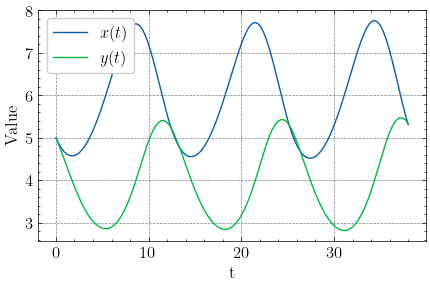

In [6]:
T = 38
alpha, beta, delta, gamma = 0.4, 0.1, 0.1, 0.6
x_0, y_0 = 5, 5
problem = LotkaVolterra(T, (alpha, beta, delta, gamma), [x_0, y_0])

plot_ode(problem.t.numpy(), [(problem.solution[0], r'$x(t)$', None), ((problem.solution[1], r'$y(t)$', None))], size=(5, 3))

In [85]:
import torch.nn as nn 

L, W = 4, 48
model = FeedForwardNetwork(L, W, input_dim=1, output_dim=2, activation=nn.Tanh()).to(device)
# model.init_weights(init.eye_)

coef = 0.2
num_iters = 15000
N_D = 2048
lr = 1e-2
collect_every = 500

loss_history, error_history, norm_history, steps = train(
    problem,
    model,
    coef, num_iters, N_D, lr,
    collect_every=collect_every, print_every=1000
)

Iteration 0 --- 56.88859372552934
Iteration 1000 --- 10.332524355236092
Iteration 2000 --- 10.056566231707805
Iteration 3000 --- 9.535001822528518
Iteration 4000 --- 9.308265487149457
Iteration 5000 --- 8.800392429459924
Iteration 6000 --- 8.26624625899455
Iteration 7000 --- 7.761704140594123
Iteration 8000 --- 6.719518423371804
Iteration 9000 --- 9.812122297664894
Iteration 10000 --- 9.555810211580512
Iteration 11000 --- 9.380653949238116
Iteration 12000 --- 8.770488189259932
Iteration 13000 --- 7.522462714948752
Iteration 14000 --- 8.353624586287232
Iteration 15000 --- 7.692743918401201


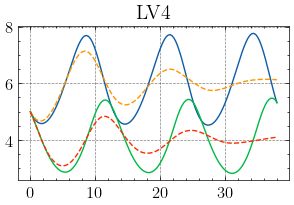

In [86]:
best_model = torch.load('./studies/saved models/lv4.pt')

preds = best_model(problem.t.reshape(-1, 1)).detach().numpy()
x = preds[:,0].flatten()
y = preds[:,1].flatten()

fig = plt.figure(figsize=(3.5, 2))

plt.plot(problem.t, problem.solution[0], label=r'$x(t)$')
plt.plot(problem.t, problem.solution[1], label=r'$y(t)$')
plt.plot(problem.t, x, label=r'$\mathcal{X}(t)$', linestyle='dashed')
plt.plot(problem.t, y, label=r'$\mathcal{Y}(t)$', linestyle='dashed')

# plt.legend()
plt.title(f'LV4')

plt.savefig(f'../images/lv4_solution.png', dpi=250)
plt.show()

In [117]:
def get_report_data(loss_history, norm_history):

    layers = norm_history[0].keys()

    layers_history = {key: list() for key in layers}
    gradients_history = {key: list() for key in layers}
    for layer in layers:
        for norms in norm_history:
            layer_norm = norms[layer][0].item()
            grad_norm = norms[layer][1].item() if norms[layer][1] is not None else None
            layers_history[layer].append(layer_norm)
            gradients_history[layer].append(grad_norm)
            
    losses=[
        (loss_history[:,0], r'$\mathcal{L_I}$'),
        (loss_history[:,1], r'$\mathcal{L_X}$'),
        (loss_history[:,2], r'$\mathcal{L_Y}$'),
        (loss_history[:,3], r'$\mathcal{L_T}$')
    ]
    
    return losses, gradients_history, layers_history

def plot_report(
    t: np.ndarray, 
    losses: np.ndarray, 
    errors: np.ndarray, 
    steps: np.ndarray, 
    gradients_history: dict, 
    layers_history: dict,
    interesting_iteration: int,
    ):

    fig, ax = plt.subplots(2, 2, figsize=(8, 6), width_ratios=[4, 3], height_ratios=[1, 1])

    for layer in gradients_history:
        if 'bias' not in layer:
            ax[0, 0].plot(t, gradients_history[layer][1:], label=layer)
    for layer in layers_history:
        if 'bias' not in layer:
            ax[0, 1].plot(t, layers_history[layer][1:], label=layer)

    ax[0, 0].title.set_text('Gradient Norms')
    ax[0, 1].title.set_text('Layer Norms')
    
    ax[0, 0].set(xticklabels=[])
    ax[0, 1].set(xticklabels=[])

    ax[0, 0].set_yscale('log')
    ax[0, 1].legend(loc='upper left', bbox_to_anchor=(-1.5, 1.5),
            ncol=3, fancybox=True, shadow=True)

    for loss, name in losses:
        ax[1, 0].plot(t, loss, label=name)
    ax[1, 1].plot(t, errors[1:], label='L2 Error')
    ax[1, 1].plot(t, steps, label='Step Norm')

    ax[1, 0].set_yscale('log')
    ax[1, 1].set_yscale('log')

    ax[1, 0].legend(ncol=2)
    ax[1, 1].legend()
    
    ax[1, 0].title.set_text('Loss Dynamics')
    ax[1, 1].title.set_text('L2 Dynamics')
    
    for i, j in [(0, 0), (0, 1), (1, 0), (1, 1)]:
        ax[i, j].axvline(x=interesting_iteration, ls=':', color='black')

    plt.savefig(f'../images/report.png', dpi=250)
    plt.show()

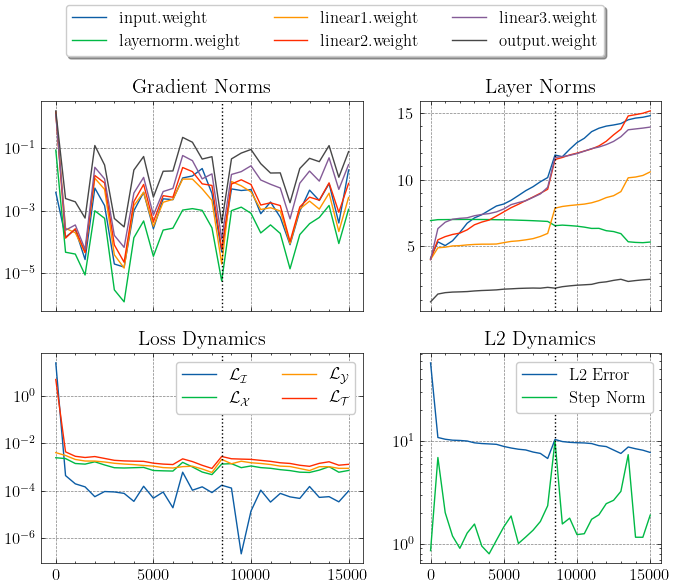

In [118]:
losses, gradients_history, layers_history = get_report_data(loss_history, norm_history)

t = np.arange(0, num_iters + 1, collect_every)
plot_report(t, losses, error_history, steps, gradients_history, layers_history, interesting_iteration = 8500)

In [16]:
import imageio
imgs = []
for filename in [f'./.temp/Iteration {i}.png' for i in range(0, num_iters+1, collect_every)]:
    imgs.append(imageio.imread(filename))
    imageio.mimsave('../images/animations/lv4_double_learning.gif', imgs, fps=60, loop=0)

C:\Temp\ipykernel_3876\1902518015.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgs.append(imageio.imread(filename))


## Interesting problem statements
---

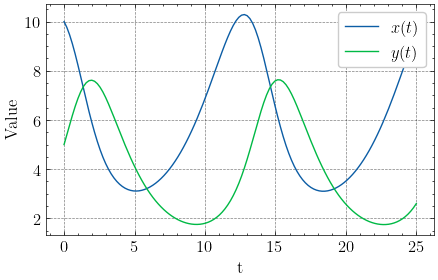

In [5]:
# Default
T = 25
alpha, beta, delta, gamma = 0.4, 0.1, 0.1, 0.6
x_0, y_0 = 10, 5
problem = LotkaVolterra(T, (alpha, beta, delta, gamma), [x_0, y_0])
plot_ode(problem.t.numpy(), [(problem.solution[0], r'$x(t)$', None), ((problem.solution[1], r'$y(t)$', None))], size=(5, 3))

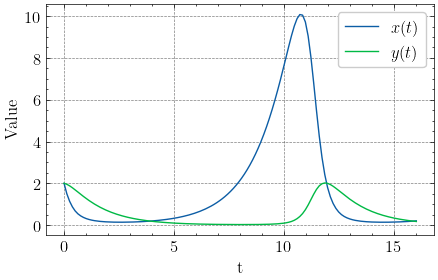

In [101]:
# Pretty sharp solution.
T = 16
alpha, beta, delta, gamma = 0.7, 1.5, 0.3, 0.7
x_0, y_0 = 2, 2
problem = LotkaVolterra(T, (alpha, beta, delta, gamma), [x_0, y_0])
plot_ode(problem.t.numpy(), [(problem.solution[0], r'$x(t)$', None), ((problem.solution[1], r'$y(t)$', None))], size=(5, 3))

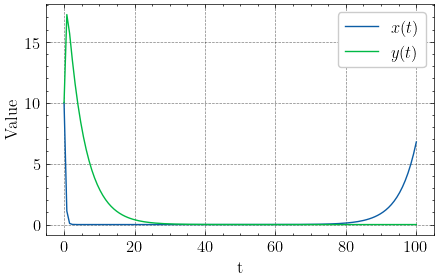

In [90]:
# This solution is exhibit pretty usual behavior for L-V system.
T = 100
alpha, beta, delta, gamma = 0.2, 0.2, 0.2, 0.2
x_0, y_0 = 10, 10
problem = LotkaVolterra(T, (alpha, beta, delta, gamma), [x_0, y_0])
plot_ode(problem.t.numpy(), [(problem.solution[0], r'$x(t)$', None), ((problem.solution[1], r'$y(t)$', None))], size=(5, 3))

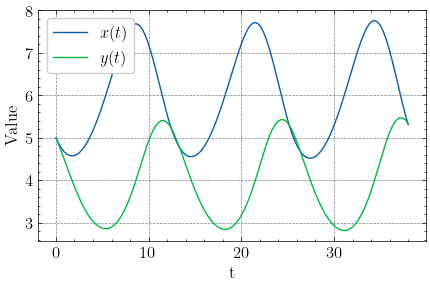

In [62]:
# Default parameters with different initialization and larger time T.
T = 38
alpha, beta, delta, gamma = 0.4, 0.1, 0.1, 0.6
x_0, y_0 = 5, 5
problem = LotkaVolterra(T, (alpha, beta, delta, gamma), [x_0, y_0])
plot_ode(problem.t.numpy(), [(problem.solution[0], r'$x(t)$', None), ((problem.solution[1], r'$y(t)$', None))], size=(5, 3))

In [28]:
def get_problem(N):
    match N:
        case 1:
            T = 25
            alpha, beta, delta, gamma = 0.4, 0.1, 0.1, 0.6
            x_0, y_0 = 10, 5
            
        case 2:
            T = 16
            alpha, beta, delta, gamma = 0.7, 1.5, 0.3, 0.7
            x_0, y_0 = 2, 2
            
        case 3:
            T = 100
            alpha, beta, delta, gamma = 0.2, 0.2, 0.2, 0.2
            x_0, y_0 = 10, 10
            
        case 4:
            T = 38
            alpha, beta, delta, gamma = 0.4, 0.1, 0.1, 0.6
            x_0, y_0 = 5, 5
    
    problem = LotkaVolterra(T, (alpha, beta, delta, gamma), [x_0, y_0])
    
    return problem

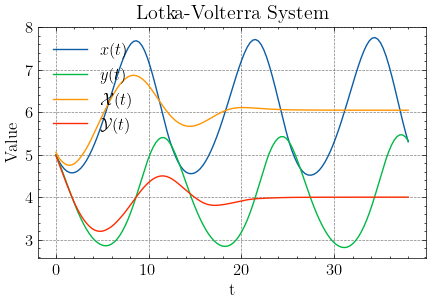

In [6]:
problem = get_problem(4)
test_model = torch.load('./studies/lv_4_best_model.pt', map_location='cpu')

preds = test_model(problem.t.reshape(-1, 1)).detach().numpy()
x = preds[:,0].flatten()
y = preds[:,1].flatten()

plot_ode(
    problem.t.numpy(), 
    solutions=[(problem.solution[0], r'$x(t)$', None), (problem.solution[1], r'$y(t)$', None)],
    predicted=[(x, r'$\mathcal{X}(t)$', None), (y, r'$\mathcal{Y}(t)$', None)],
    title='Lotka-Volterra System', size=(5, 3)
)

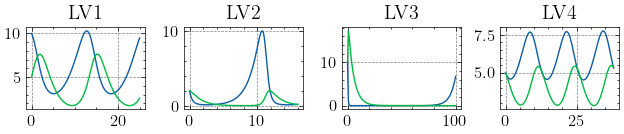

In [8]:
problems = [get_problem(i) for i in range(1, 5)]

size = (10*0.65, 2 * 0.8)
fig, axs = plt.subplots(1, 4, figsize=size)
for i, problem in enumerate(problems):
    axs[i].plot(problem.t, problem.solution[0])
    axs[i].plot(problem.t, problem.solution[1])
    axs[i].title.set_text(f'LV{i+1}')
plt.tight_layout()

plt.savefig('../images/lv_grid.png', dpi=250)
plt.show()

## Hyperparameters tuning
---

In [31]:
import optuna

best_model = None
model = None

study_name = None

def objective(trial):
    
    global model
    
    L = trial.suggest_int('L', 2, 6, step=2)
    W = trial.suggest_int('W', 32, 128, step=32)
    
    # activation = trial.suggest_categorical('activation', ['tanh', 'tanh'])
    model = FeedForwardNetwork(L, W, input_dim=1, output_dim=2).to(device)
    # init_rule = trial.suggest_categorical('initialization', ['default', 'zeros', 'eye', 'normal'])
    
    N_D = trial.suggest_int('N_D', 512, 1024 * 4, step=512)
    lr = trial.suggest_float('lr', 1e-3, 1e-1, log=True)
    
    coef = trial.suggest_float('coef', 0.05, 0.95)
    
    # if init_rule == 'zeros':
    #     model.init_weights(init.zeros_)
    # elif init_rule == 'eye':
    #     model.init_weights(init.eye_)
    # else: 
    #     model.init_weights(init.normal_)
        
    torch.save(model, f'./studies/saved models/{study_name}_{trial.number}.pt')
    
    # sampling = trial.suggest_categorical('sampling', ['random', 'grid'])
    
    sampling = 'grid'
    if sampling == 'random':
        collocation_points = torch.tensor(np.random.uniform(0, problem.T, N_D), dtype=torch. float32, requires_grad=True).reshape(-1, 1).to(device)
    else:
        collocation_points = torch.linspace(0, problem.T, N_D, requires_grad=True).reshape(-1, 1).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for i in range(15000):

        optimizer.zero_grad()

        L_I = problem.loss_initial(model)
        L_X, L_Y = problem.loss_physical(model, collocation_points)

        L = coef * L_I + (1 - coef) * (L_X + L_Y)

        L.backward()
        optimizer.step()
        
        if (i + 1) % 1000 == 0:
            preds = model(problem.t.reshape(-1, 1)).detach().cpu().numpy()
            x, y = preds[:,0].flatten(), preds[:,1].flatten()
            error = (l2(x, problem.solution[0]) + l2(y, problem.solution[1])) / 2
            
            trial.report(error, i + 1)
            
            if trial.should_prune():
                raise optuna.TrialPruned()
            
    return error

def callback(study, trial):
    global best_model
    
    if study.best_trial == trial:
        best_model = model

In [32]:
for problem_number in range(1, 2):
    problem = get_problem(problem_number)

    study = optuna.create_study(
        study_name=f'lv_{problem_number}',
        direction='minimize', 
        sampler=optuna.samplers.TPESampler(),
        pruner=optuna.pruners.HyperbandPruner(max_resource=15000)
        )
    
    study_name = study.study_name

    study.optimize(objective, n_trials=50, callbacks=[callback])
    study.trials_dataframe().to_csv(f'./studies/{study_name}.csv', sep=',')
        
    torch.save(best_model, f'./studies/{study_name}_best_model.pt')

[I 2024-04-03 16:25:01,351] A new study created in memory with name: lv_1
[W 2024-04-03 16:25:06,812] Trial 0 failed with parameters: {'L': 6, 'W': 128, 'initialization': 'default', 'N_D': 6144, 'lr': 0.0015085692865496035, 'coef': 0.5170240584671877, 'sampling': 'random'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\dlaptev\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Temp\ipykernel_16376\3530040992.py", line 49, in objective
    L.backward()
  File "c:\Users\dlaptev\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\_tensor.py", line 492, in backward
    torch.autograd.backward(
  File "c:\Users\dlaptev\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\autograd\__init__.py", line 251, in backward
    Variable._execution_engine.run_backward(  # Calls into th

KeyboardInterrupt: 

In [ ]:
test_model = torch.load(f'./studies/lv_1_best_model.pt', map_location='cpu')

preds = test_model(problem.t.reshape(-1, 1)).detach().numpy()
x, y = preds[:,0].flatten(), preds[:,1].flatten()

plot_ode(
    problem.t.numpy(), 
    solutions=[(problem.solution[0], r'$x(t)$', None), (problem.solution[1], r'$y(t)$', None)],
    predicted=[(x, r'$\mathcal{X}(t)$', None), (y, r'$\mathcal{Y}(t)$', None)],
    title='Lotka-Volterra System', size=(5, 3)
)

## Hyperparameter analysis
---

In [1]:
import pandas as pd
from modules.utils import get_corr, plot_rmse_corr

In [2]:
new_names = ['l2', 'L', 'N_D', 'W', 'init', 'lr', 'w1', 'w2', 'w3', 'iters']

lv1 = pd.read_csv('./studies/lv_1.csv', index_col=0).drop(['number', 'datetime_start', 'datetime_complete'], axis=1)
lv2 = pd.read_csv('./studies/lv_2.csv', index_col=0).drop(['number', 'datetime_start', 'datetime_complete'], axis=1)
lv3 = pd.read_csv('./studies/lv_3.csv', index_col=0).drop(['number', 'datetime_start', 'datetime_complete'], axis=1)
lv4 = pd.read_csv('./studies/lv_4.csv', index_col=0).drop(['number', 'datetime_start', 'datetime_complete'], axis=1)

# for df in [lv1, lv2, lv3, lv4]:
#     df.columns = new_names

FileNotFoundError: [Errno 2] No such file or directory: './studies/lv_1.csv'

[]

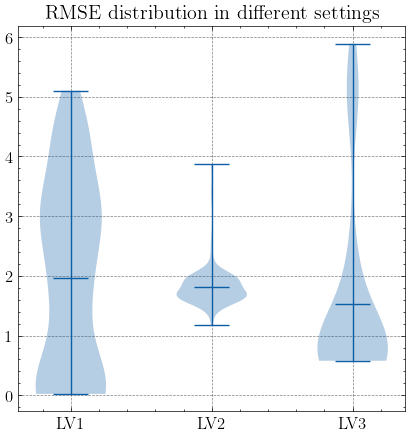

In [12]:
fig = plt.figure(figsize=(5, 5))
plt.violinplot(
    [lv1['rmse'].to_numpy(), lv2['rmse'].to_numpy(), lv3['rmse'].to_numpy(), lv4['rmse'].to_numpy()],
    showextrema=True, showmeans=True
)

plt.title('RMSE distribution in different settings')
plt.xticks(ticks=[1, 2, 3, 4], labels=['LV1', 'LV2', 'LV3', 'LV4'])
plt.plot()

Instances of group...
eye - 46
normal - 9
zeros - 45


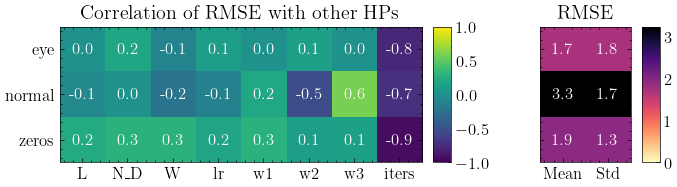

In [13]:
correlation, rmse_data, xlabels, ylabels = get_corr(lv1)
plot_rmse_corr(correlation, rmse_data, xlabels, ylabels)

Instances of group...
eye - 14
normal - 74
zeros - 12


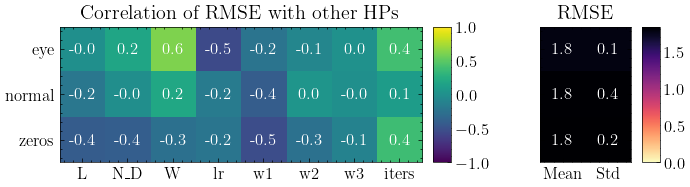

In [14]:
correlation, rmse_data, xlabels, ylabels = get_corr(lv2)
plot_rmse_corr(correlation, rmse_data, xlabels, ylabels)

Instances of group...
eye - 74
normal - 10
zeros - 16


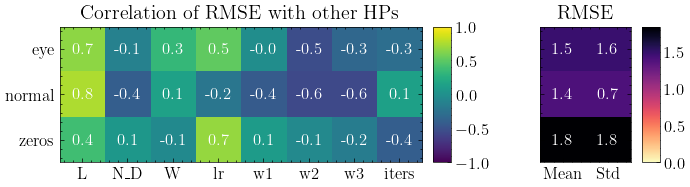

In [15]:
correlation, rmse_data, xlabels, ylabels = get_corr(lv3)
plot_rmse_corr(correlation, rmse_data, xlabels, ylabels)

In [ ]:
correlation, rmse_data, xlabels, ylabels = get_corr(lv4)
plot_rmse_corr(correlation, rmse_data, xlabels, ylabels)